# **XPM 1D Hermite-Gauss Basis Inverse Design**
We assume equations of form:
$$
\frac{\partial A_1}{\partial z} 
= - i\frac{\beta_{21}}{2} \frac{\partial^2 A_1}{\partial T^2} + i\gamma_1 \bigl[ |A_1|^2 + 2|A_2|^2 \bigr]A_1 = \bigl[ \mathscr{L_1} + \mathscr{N}_1  \bigr] A_1
$$
$$
\frac{\partial A_2}{\partial z}  
= -
i\frac{\beta_{22}}{2} \frac{\partial^2 A_2}{\partial T^2} + i\gamma_2 \bigl[ |A_2|^2 + 2|A_1|^2 \bigr]A_2 =  \bigl[ \mathscr{L_2} + \mathscr{N}_2  \bigr] A_2
$$


In [1]:
# general imports
import numpy as np
import matplotlib.pyplot as plt

# ml imports
import torch
import torch.nn.functional as F
from tqdm import tqdm

# import module
from nlse import *

## **Universal Parameters**

In [2]:
# define simulation parameters used in inverse design
Lz = 1e-3               # Propagation distance in km (1cm = 1e-5)
Nz = 100               # Number of steps in z
dz = Lz / Nz            # Step size in z
Lt = 4                  # Temporal window size
Nt = 1024               # Number of temporal points
dt = Lt / Nt
N_modes = 10

# define medium parameters
beta2_j = -10           # anomalous GVD region
beta2_k = -10           # anomalous GVD region
gamma_j = 1
gamma_k = 1

# define pulse parameters
tau = 0.1               # temporal width of the pulse = 100 fs - also, characteristic time of Hermite-Gauss basis used in simulation

In [3]:
# define HG basis
t = torch.linspace(-Lt/2, Lt/2, Nt)
hg_basis = get_hg_basis(N_modes, t, tau)

Precomputed 10 HG basis functions on grid of 1024 points


## **Useful Functions**

In [ ]:
def gaussian_pulse(t, center=0.0, T0=0.5, A0=0.01): # A0 = P0**2
    """Generate a Gaussian pulse using PyTorch."""
    return A0 * torch.exp(-((t - center) ** 2) / (2 * T0 ** 2))

def sech_pulse(t, center=0.0, T0=1.0, A0=1.0):
    """Generate a Gaussian pulse."""
    return A0* 1/torch.cosh( (t-center)/ T0 + 1e-16) + 1e-16

def square_pulse(t, center=0.0, w=1.0, A0=1.0):
    """Generate a square pulse using PyTorch."""
    return A0 * ((t >= center - w/2) & (t <= center + w/2))

def supergaussian_pulse(t, energy=1.0, tau=1.0, m=1):
    """Generate a super-Gaussian pulse with specified energy, width, and order."""
    # Shape function f(t) = exp[-(t/tau)^(2m)]
    shape = torch.exp(-((t / tau) ** (2 * m)))
    
    # Calculate normalization factor A0 to achieve desired energy
    dt_val = t[1] - t[0]  # assuming uniform spacing
    energy_shape = torch.sum(shape**2) * dt_val
    A0 = torch.sqrt(energy / energy_shape)
    
    return A0 * shape



def strong_soliton(t, beta2_k, gamma_k, tau):
    """Create the strong pulse (A_k) based on the soliton parameters."""
    # calculate secondary parameters
    a_2_squared = -beta2_k / (gamma_k * tau**2)
    a_2 = np.sqrt(a_2_squared)
    
    # Define strong pulse waveform
    Ain_k = a_2 * torch.cosh(t / tau)**(-1)
    
    return Ain_k

def weak_soliton(t, beta2_k, beta2_j, gamma_j, gamma_k, tau, amplitude_ratio=100.0):
    """Create the weak pulse (A_j) based on the soliton parameters."""
    # calculate secondary parameters
    a_2_squared = -beta2_k / (gamma_k * tau**2)
    a_2 = np.sqrt(a_2_squared)
    a_1 = a_2 / amplitude_ratio
    
    # For the weak pulse A_1 (soliton-like):
    p = 0.5 * (-1 + np.sqrt(1 + 16 * beta2_k * gamma_j / (beta2_j * gamma_k)))
    
    # Define weak pulse waveform
    Ain_j = a_1 * (torch.cosh(t / tau)**(-1))**p
    
    return Ain_j

## **Testing**

### Conversion to HG Basis

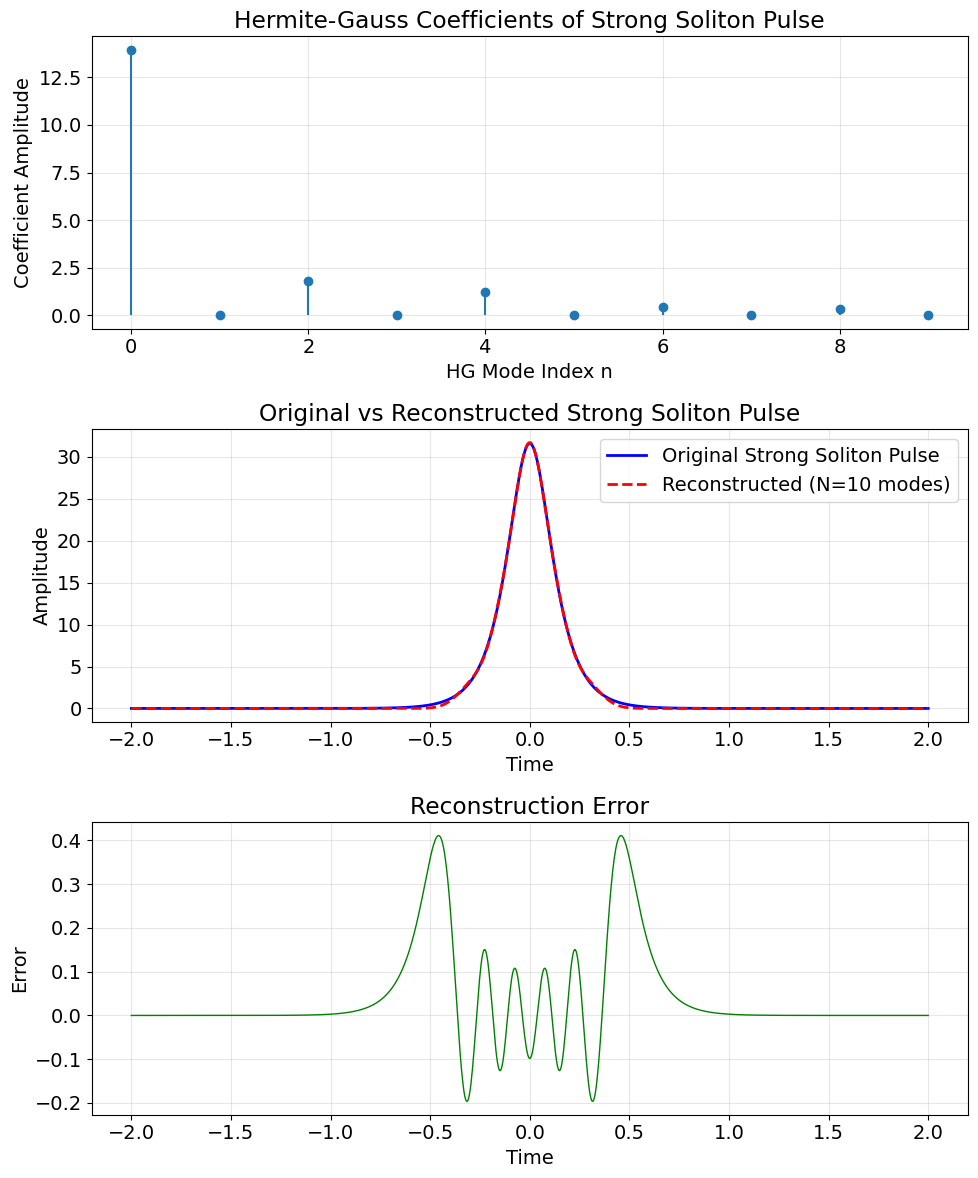

Original pulse energy: 199.999817
Reconstructed pulse energy: 199.945842
RMS error: 0.115671
Max coefficient magnitude: 13.956455
Number of significant coefficients (>1% of max): 5


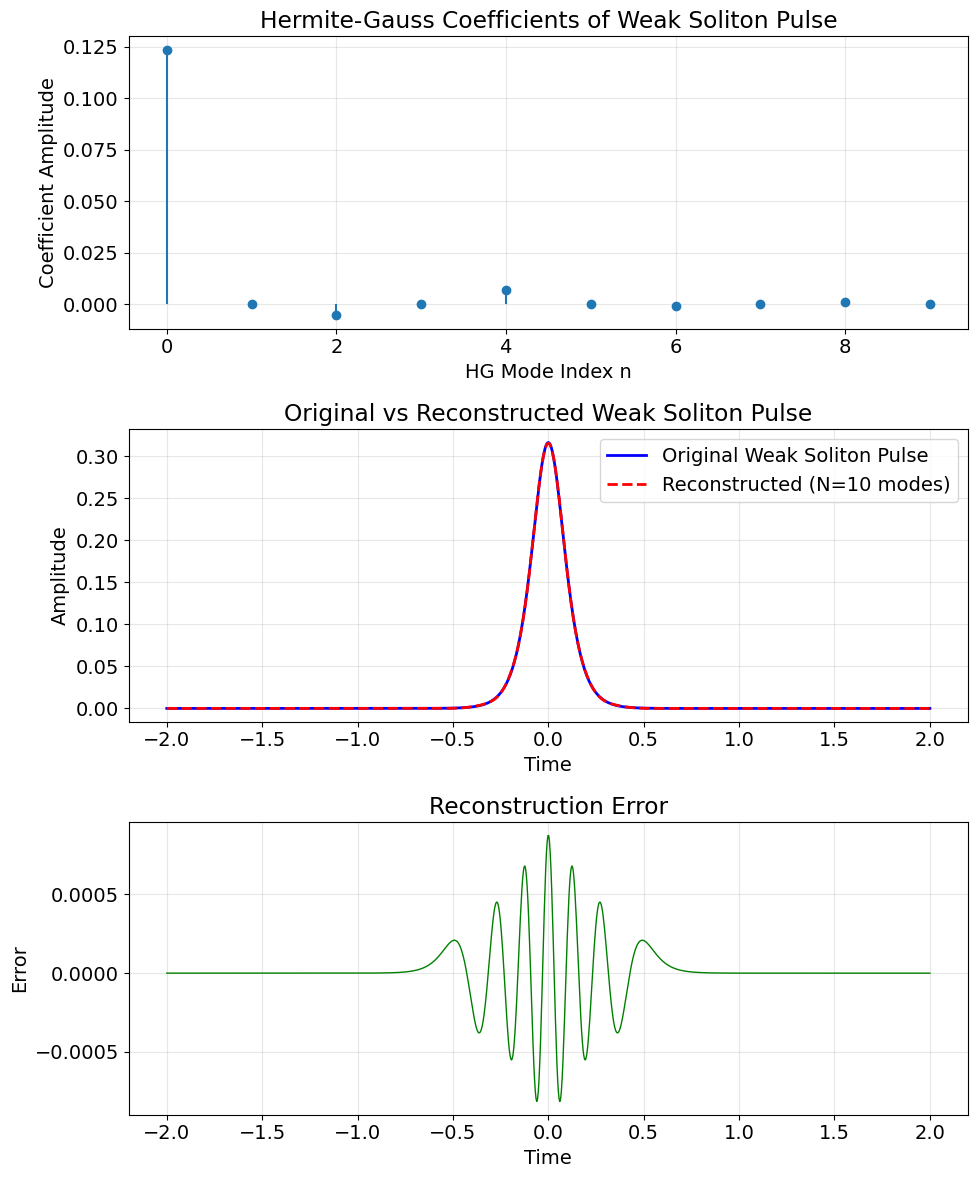

Original pulse energy: 0.015347
Reconstructed pulse energy: 0.015347
RMS error: 0.000199
Max coefficient magnitude: 0.123562
Number of significant coefficients (>1% of max): 3


In [5]:
# define pulses
A_strong = strong_soliton(t, beta2_k, gamma_k, tau)
A_weak = weak_soliton(t, beta2_k, beta2_j, gamma_j, gamma_k, tau)

# convert to HG basis
A_strong_hg = time_to_hg(A_strong, hg_basis, dt)
A_weak_hg = time_to_hg(A_weak, hg_basis, dt)

# reconstruct pulse
A_strong_reconstructed = hg_to_time(A_strong_hg, hg_basis)
A_weak_reconstructed = hg_to_time(A_weak_hg, hg_basis)

# analyze pulse
err_strong = analyze_pulse_in_hg_basis(A_strong, hg_basis, t, "Strong Soliton Pulse")
err_weak = analyze_pulse_in_hg_basis(A_weak, hg_basis, t, "Weak Soliton Pulse")


### Simulation

In [6]:
# independent variable (we use torch for automatic differentiation)
t = torch.linspace(-Lt/2, Lt/2, Nt) 

Ain_j = A_weak
Ain_k = A_strong

# Perform the split-step Fourier method
A_j_evolution, A_k_evolution  = split_step_fourier_xpm(Ain_j, Ain_k, dz, Nz, beta2_j, beta2_k, gamma_j, gamma_k, Lt)

### Plotting

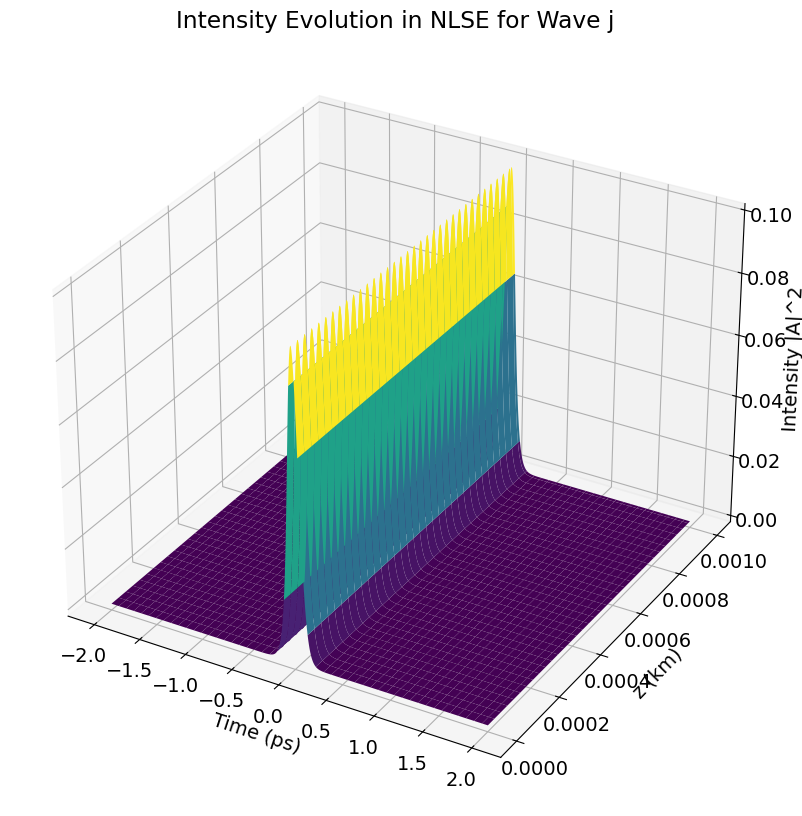

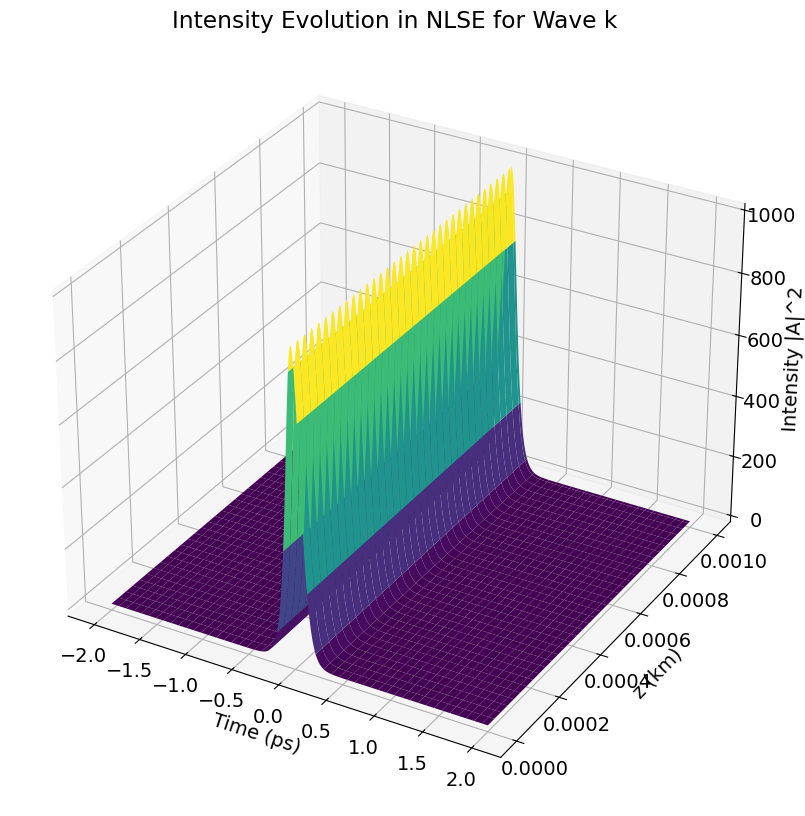

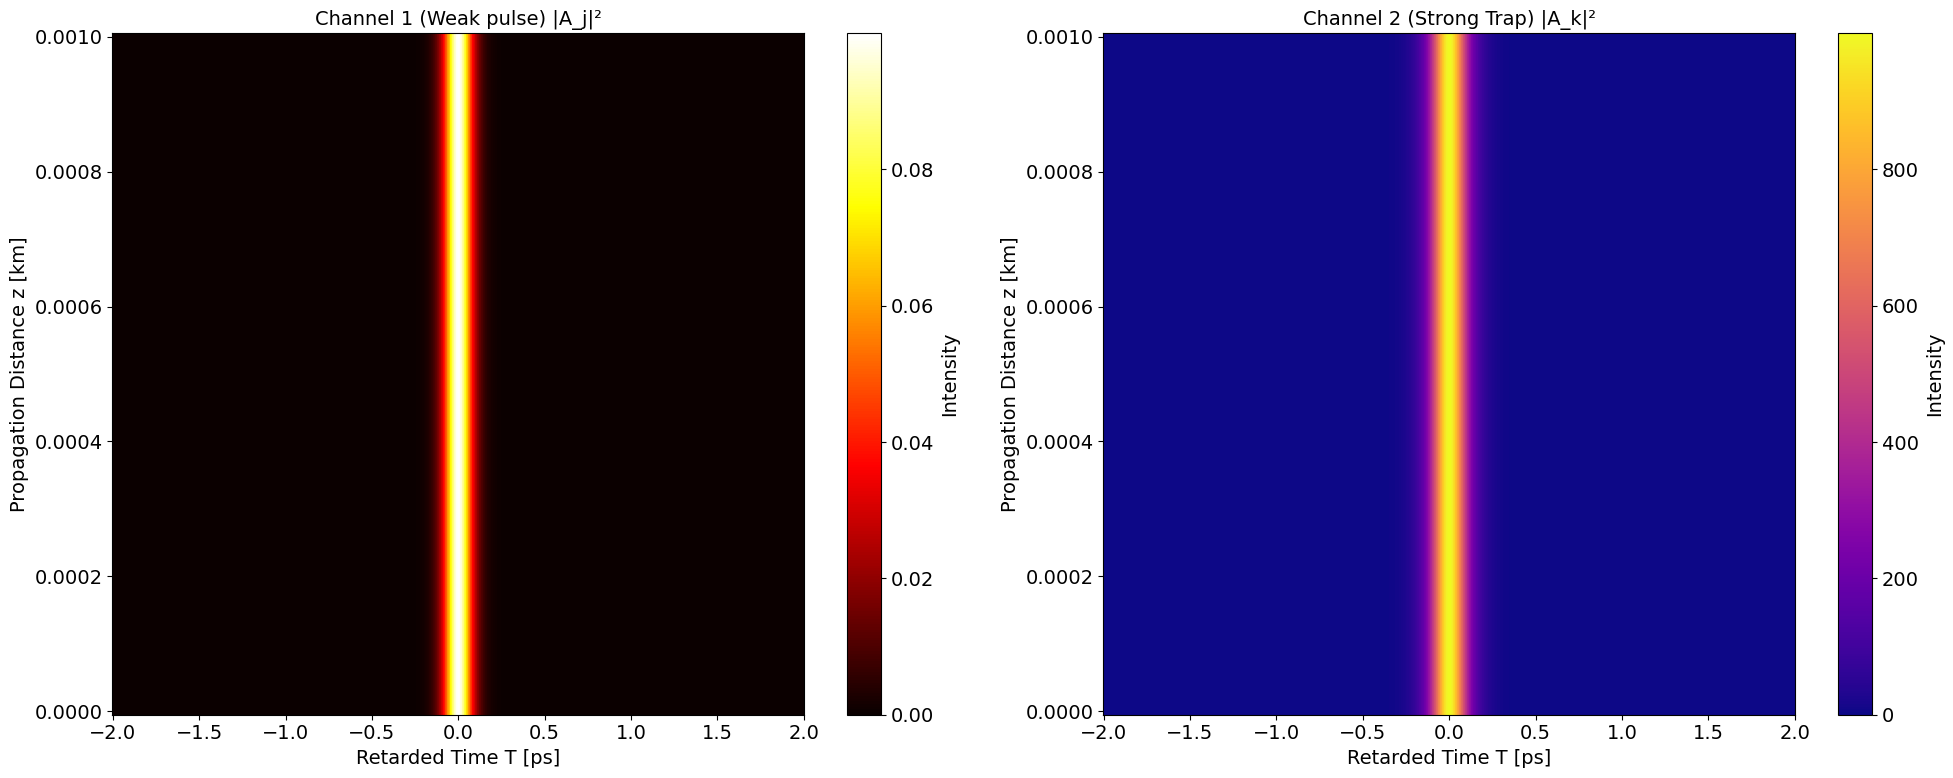

In [7]:
plot_intensity_evolution(A_j_evolution, t, Lz, Nz, wave_name='Wave j')
plot_intensity_evolution(A_k_evolution, t, Lz, Nz, wave_name='Wave k')
plot_cowave_evolution(A_j_evolution.detach().clone(), A_k_evolution.detach().clone(), t, Lz, Nz)

### Evaluation

In [8]:
# Energy should be conserved (no loss)
print(f"Initial energy of wave j: {get_energy(A_j_evolution[:,0], dt):.8f} wave k: {get_energy(A_k_evolution[:,0], dt):.4f}")
print(f"Final energy of wave j: {get_energy(A_j_evolution[:,-1], dt):.8f} wave k: {get_energy(A_k_evolution[:,-1], dt):.4f}")

Initial energy of wave j: 0.01533207 wave k: 199.8047
Final energy of wave j: 0.01533222 wave k: 199.8062


## **Inverse Design 1: Square Wave**

### Training Parameters

In [9]:
# define target parameters
w = 0.5 # width of square wave target (ps)

# define simulation parameters
mask_percent = 0.5 # size of the unpenalized region in percent of the total temporal window
m = 8 # number of slices to check for penalty
w_mse = 1e4
w_pen = 1e3 # penalty weight
lr = 1e-1
N_train = 500

### Initialization
We have to initialize the inout waveforms and also **define the target**. Note that since energy is conserved the square wave must have the same energy as the weak input wave.

We set the (temporal) width of the target arbitrarily as $w = 3 \, ps$. Defining it's amplitude as $A_s$ it's total energy would be $E = A_s^2 \cdot w$ and thus
$$A_s = \sqrt{\frac{E}{w}} $$

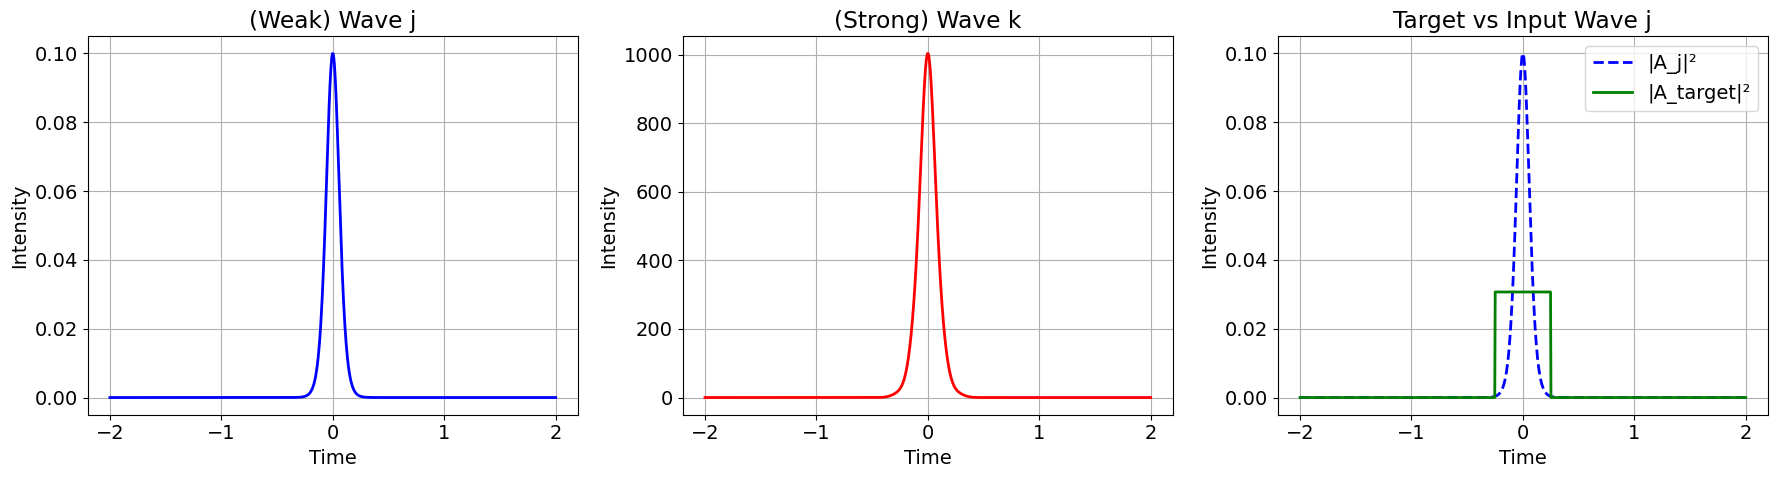

Optimizing HG basis coefficient theta of size 10


In [10]:
""" define inputs """
# define inputs
t = torch.linspace(-Lt/2, Lt/2, Nt) 
theta = torch.nn.Parameter(A_strong_hg.clone().detach().requires_grad_(True)) # our controllable parameters - the coefficients of A_strong in the HG basis
Ain_j = A_weak
Ain_k = hg_to_time(theta, hg_basis)

# define target
Ein = get_energy(Ain_j, dt)
A_s = np.sqrt(Ein/w)
A_target = square_pulse(t, center=0.0, w=w, A0=A_s)

# plot input waveforms
plot_inputs_and_target(Ain_j, Ain_k, A_target, t)


""" define training functions and objects """
# define penalty mask (takes values of 1 where the wave is not allowed to have nonzero values)
penalty = torch.zeros_like(t)
penalty[:int(Nt/2-Nt*mask_percent/2)] = 1
penalty[int(Nt/2+Nt*mask_percent/2):] = 1
iters = np.linspace(0, Nz-1, m).astype(int)

# define loss function
def loss_function(A_j_evolution, A_k_evolution):
    
    # mse loss 
    mse_loss = F.mse_loss(torch.abs(A_j_evolution[:, -1])**2, torch.abs(A_target)**2)

    # penalization loss - to enforce none of the waves to stray outside the simulation bounds
    pen_loss = 0    
    for i in iters:  
        pen_loss += F.mse_loss(torch.abs(A_k_evolution[:, i]*penalty)**2, torch.zeros(Nt)) 
   
    return w_mse * mse_loss, w_pen * pen_loss

# define forward pass
def forward(theta, hg_basis): # in-> Ain_k, out-> A_evolution[:, -1]
    return split_step_fourier_xpm(Ain_j, hg_to_time(theta, hg_basis), dz, Nz, beta2_j, beta2_k, gamma_j, gamma_k, Lt)

# initialize optimizer
optimizer = torch.optim.Adam([theta], lr=lr)


print(f"Optimizing HG basis coefficient theta of size {theta.shape[0]}")


### Training

In [11]:
losses_mse = []
losses_pen = []
losses = []
for i in tqdm(range(N_train), desc="Training"):
    optimizer.zero_grad()
    A_j_evolution, A_k_evolution = forward(theta, hg_basis)
    loss_mse, loss_pen = loss_function(A_j_evolution, A_k_evolution)
    loss = loss_mse + loss_pen
    
    loss.backward()
    optimizer.step()

    # save and print the loss every {n} iterations
    if i % 1 == 0:
        losses_mse.append(loss_mse.item())
        losses_pen.append(loss_pen.item())
        losses.append(loss.item())
        #print(f"Iteration {i+1:3d}/{N_train}: Total Loss: {loss.item():.6f} | MSE: {loss_mse.item():.6f} | Penalty: {loss_pen.item():.6f}")

Training: 100%|██████████| 500/500 [02:37<00:00,  3.18it/s]


### Evaluation

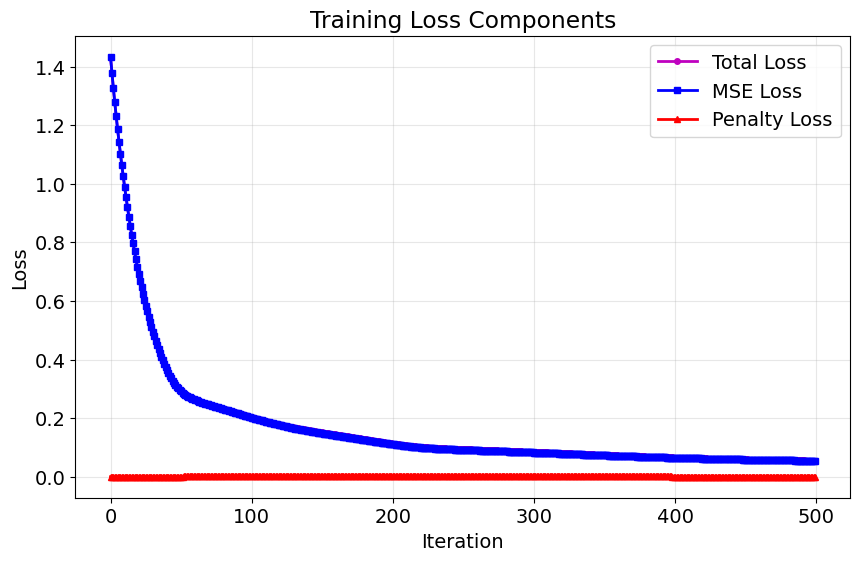

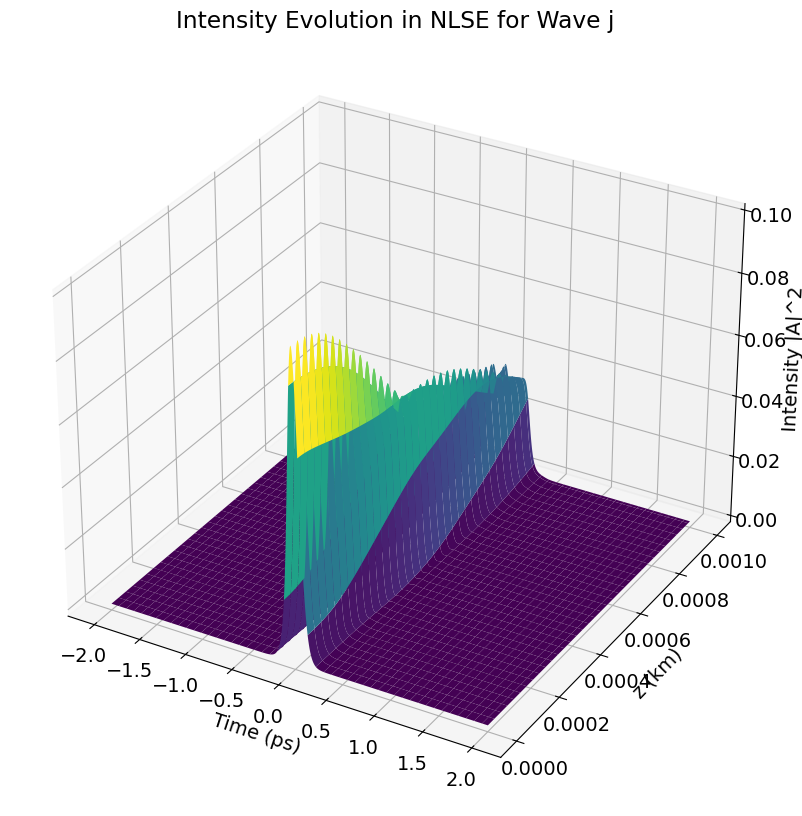

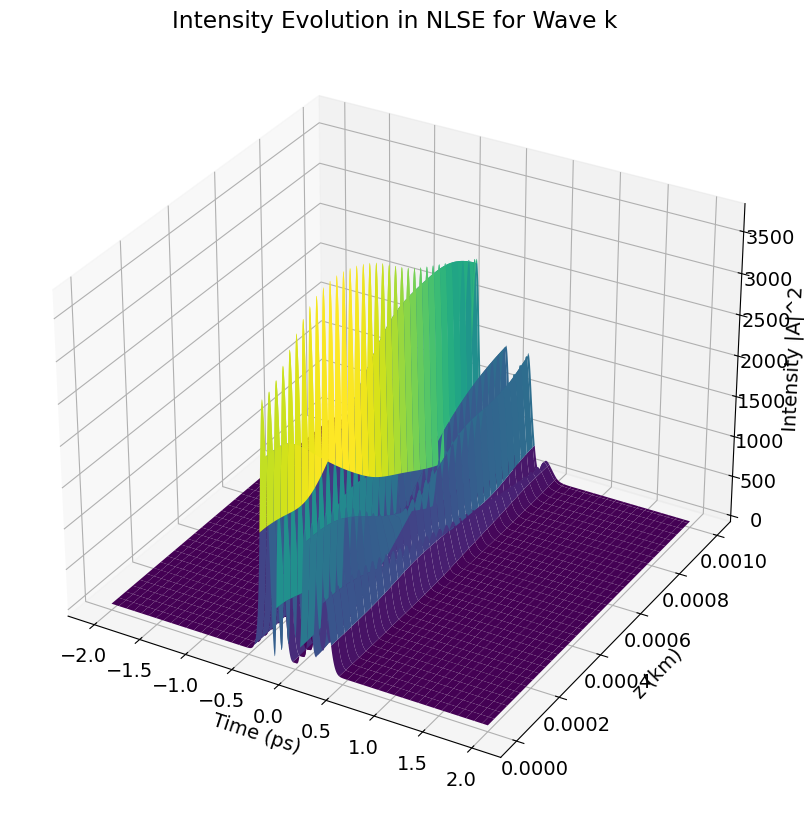

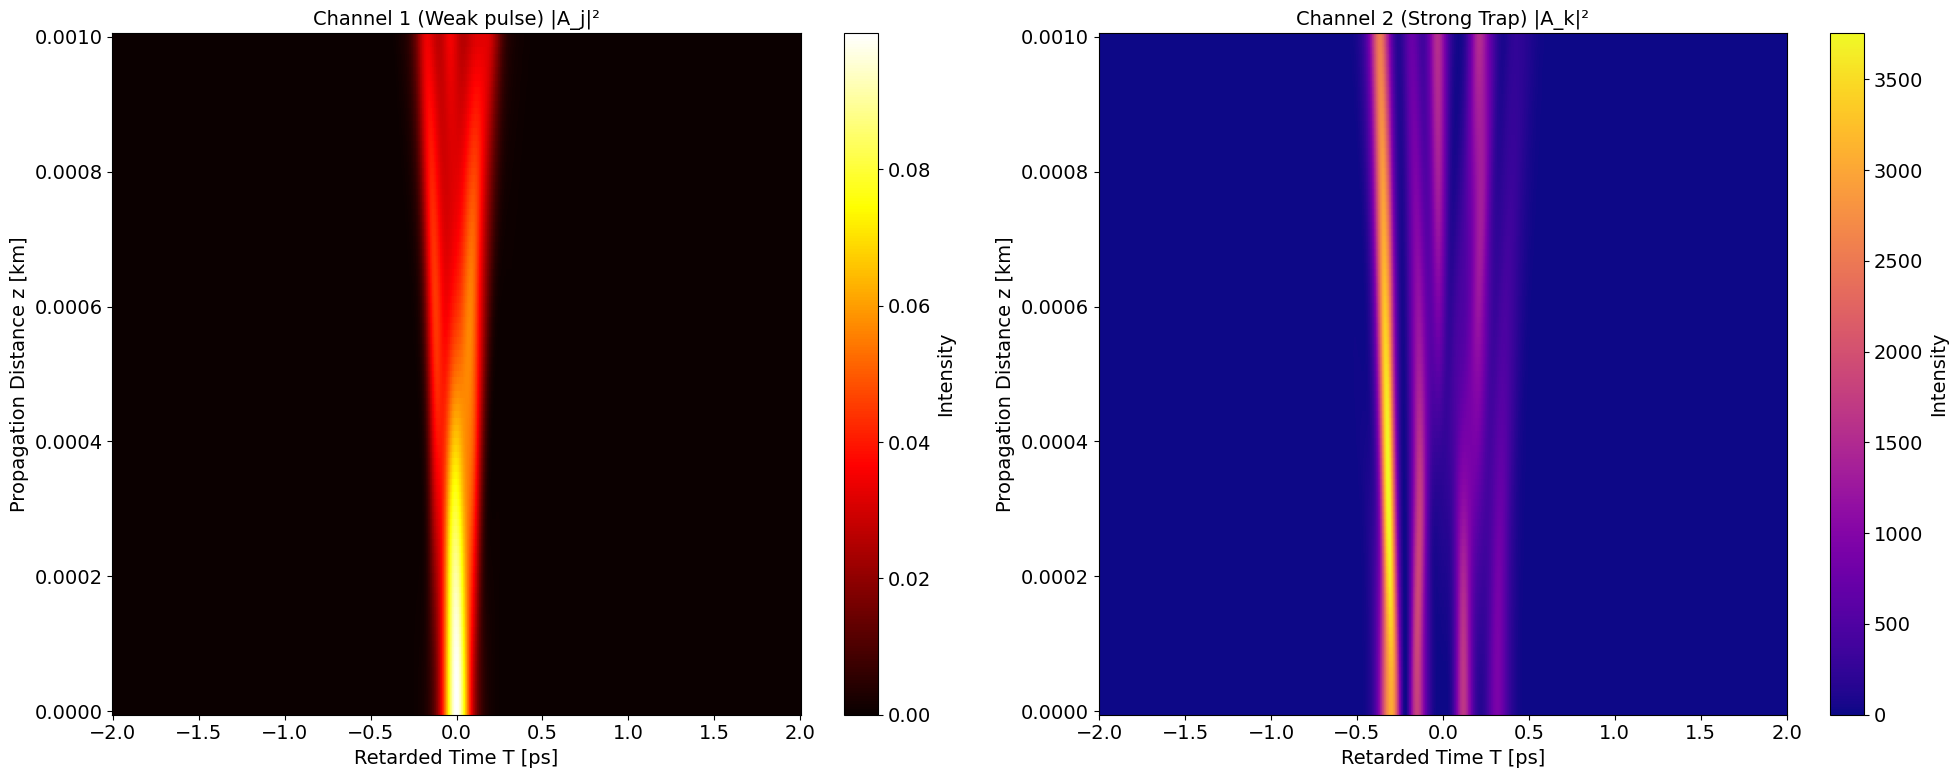

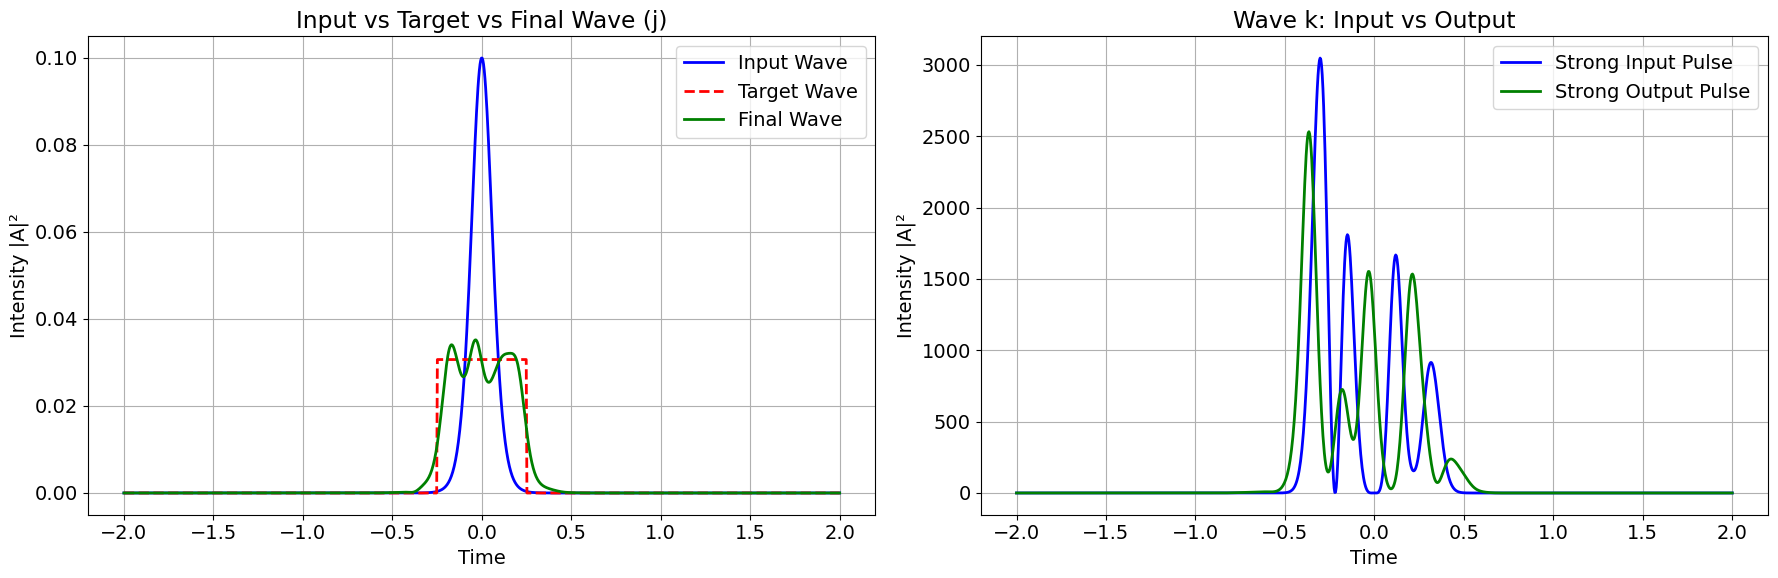

In [12]:
# plot the loss
plt.figure(figsize=(10, 6))
plt.plot(losses, color='m', marker="o", label='Total Loss', linewidth=2, markersize=4)
plt.plot(losses_mse, color='b', marker="s", label='MSE Loss', linewidth=2, markersize=4)
plt.plot(losses_pen, color='r', marker="^", label='Penalty Loss', linewidth=2, markersize=4)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss Components')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# plot the evolution of the waves
plot_intensity_evolution(A_j_evolution, t, Lz, Nz, wave_name='Wave j')
plot_intensity_evolution(A_k_evolution, t, Lz, Nz, wave_name='Wave k')
plot_cowave_evolution(A_j_evolution.detach().clone(), A_k_evolution.detach().clone(), t, Lz, Nz)
# plot the target vs the final wave
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# First subplot: Wave j comparison
ax1.plot(t, np.abs(Ain_j.detach().cpu().numpy())**2, 'b-', label='Input Wave', linewidth=2)
ax1.plot(t, np.abs(A_target.detach().cpu().numpy())**2, 'r--', label='Target Wave', linewidth=2)
ax1.plot(t, np.abs(A_j_evolution[:, -1].detach().cpu().numpy())**2, 'g-', label='Final Wave', linewidth=2)
ax1.set_xlabel('Time')
ax1.set_ylabel('Intensity |A|²')
ax1.set_title('Input vs Target vs Final Wave (j)')
ax1.legend()
ax1.grid()

# Second subplot: Wave k first and last
ax2.plot(t, np.abs(A_k_evolution[:, 0].detach().cpu().numpy())**2, 'b-', label='Strong Input Pulse', linewidth=2)
ax2.plot(t, np.abs(A_k_evolution[:, -1].detach().cpu().numpy())**2, 'g-', label='Strong Output Pulse', linewidth=2)
ax2.set_xlabel('Time')
ax2.set_ylabel('Intensity |A|²')
ax2.set_title('Wave k: Input vs Output')
ax2.legend()
ax2.grid()

plt.tight_layout()
plt.show()



## **Inverse Design 2: Supergaussian**

### Training Parameters

In [ ]:
# define target parameters
w = 0.5 # width of square wave target (ps)

# define simulation parameters
mask_percent = 0.5 # size of the unpenalized region in percent of the total temporal window
m = 8 # number of slices to check for penalty
w_mse = 1e4
w_pen = 1e3 # penalty weight
lr = 1e-1
N_train = 500

### Initialization
We have to initialize the inout waveforms and also **define the target**. Note that since energy is conserved the square wave must have the same energy as the weak input wave.

We set the (temporal) width of the target arbitrarily as $w = 3 \, ps$. Defining it's amplitude as $A_s$ it's total energy would be $E = A_s^2 \cdot w$ and thus
$$A_s = \sqrt{\frac{E}{w}} $$

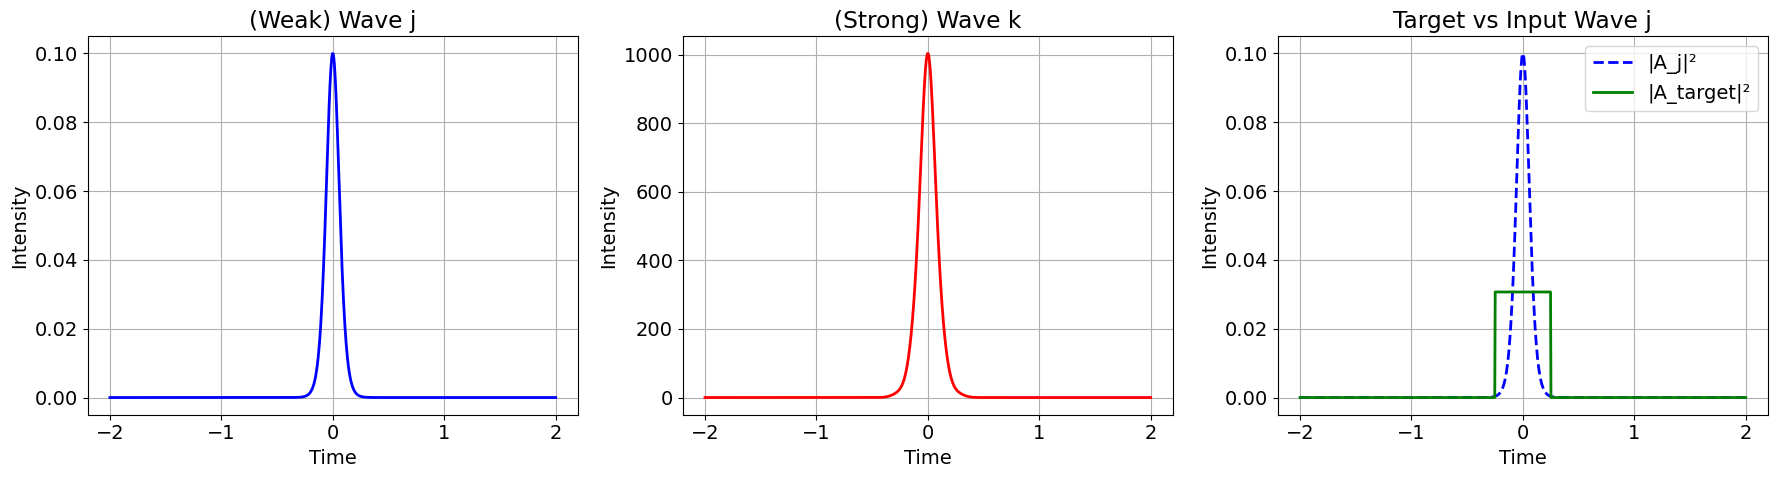

Optimizing HG basis coefficient theta of size 10


In [ ]:
""" define inputs """
# define inputs
t = torch.linspace(-Lt/2, Lt/2, Nt) 
theta = torch.nn.Parameter(A_strong_hg.clone().detach().requires_grad_(True)) # our controllable parameters - the coefficients of A_strong in the HG basis
Ain_j = A_weak
Ain_k = hg_to_time(theta, hg_basis)

# define target
Ein = get_energy(Ain_j, dt)
A_s = np.sqrt(Ein/w)
A_target = square_pulse(t, center=0.0, w=w, A0=A_s)

# plot input waveforms
plot_inputs_and_target(Ain_j, Ain_k, A_target, t)


""" define training functions and objects """
# define penalty mask (takes values of 1 where the wave is not allowed to have nonzero values)
penalty = torch.zeros_like(t)
penalty[:int(Nt/2-Nt*mask_percent/2)] = 1
penalty[int(Nt/2+Nt*mask_percent/2):] = 1
iters = np.linspace(0, Nz-1, m).astype(int)

# define loss function
def loss_function(A_j_evolution, A_k_evolution):
    
    # mse loss 
    mse_loss = F.mse_loss(torch.abs(A_j_evolution[:, -1])**2, torch.abs(A_target)**2)

    # penalization loss - to enforce none of the waves to stray outside the simulation bounds
    pen_loss = 0    
    for i in iters:  
        pen_loss += F.mse_loss(torch.abs(A_k_evolution[:, i]*penalty)**2, torch.zeros(Nt)) 
   
    return w_mse * mse_loss, w_pen * pen_loss

# define forward pass
def forward(theta, hg_basis): # in-> Ain_k, out-> A_evolution[:, -1]
    return split_step_fourier_xpm(Ain_j, hg_to_time(theta, hg_basis), dz, Nz, beta2_j, beta2_k, gamma_j, gamma_k, Lt)

# initialize optimizer
optimizer = torch.optim.Adam([theta], lr=lr)


print(f"Optimizing HG basis coefficient theta of size {theta.shape[0]}")


### Training

In [ ]:
losses_mse = []
losses_pen = []
losses = []
for i in tqdm(range(N_train), desc="Training"):
    optimizer.zero_grad()
    A_j_evolution, A_k_evolution = forward(theta, hg_basis)
    loss_mse, loss_pen = loss_function(A_j_evolution, A_k_evolution)
    loss = loss_mse + loss_pen
    
    loss.backward()
    optimizer.step()

    # save and print the loss every {n} iterations
    if i % 1 == 0:
        losses_mse.append(loss_mse.item())
        losses_pen.append(loss_pen.item())
        losses.append(loss.item())
        #print(f"Iteration {i+1:3d}/{N_train}: Total Loss: {loss.item():.6f} | MSE: {loss_mse.item():.6f} | Penalty: {loss_pen.item():.6f}")

Training: 100%|██████████| 500/500 [02:37<00:00,  3.18it/s]


### Evaluation

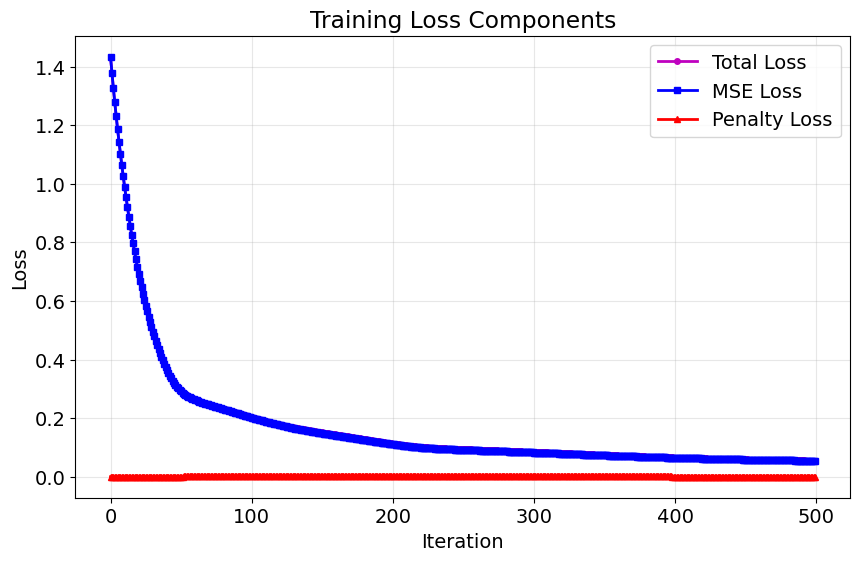

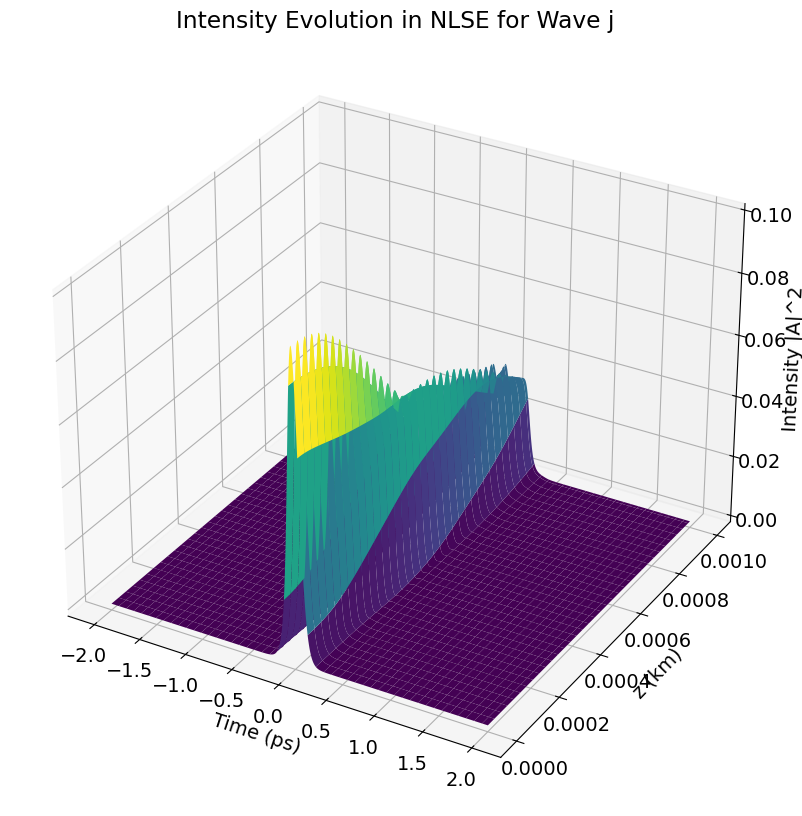

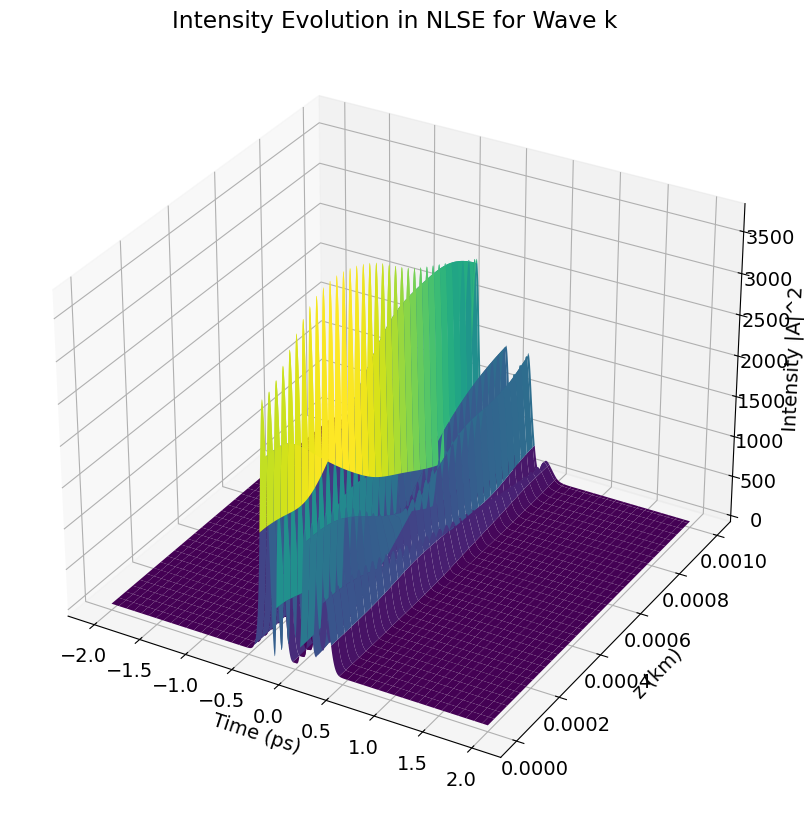

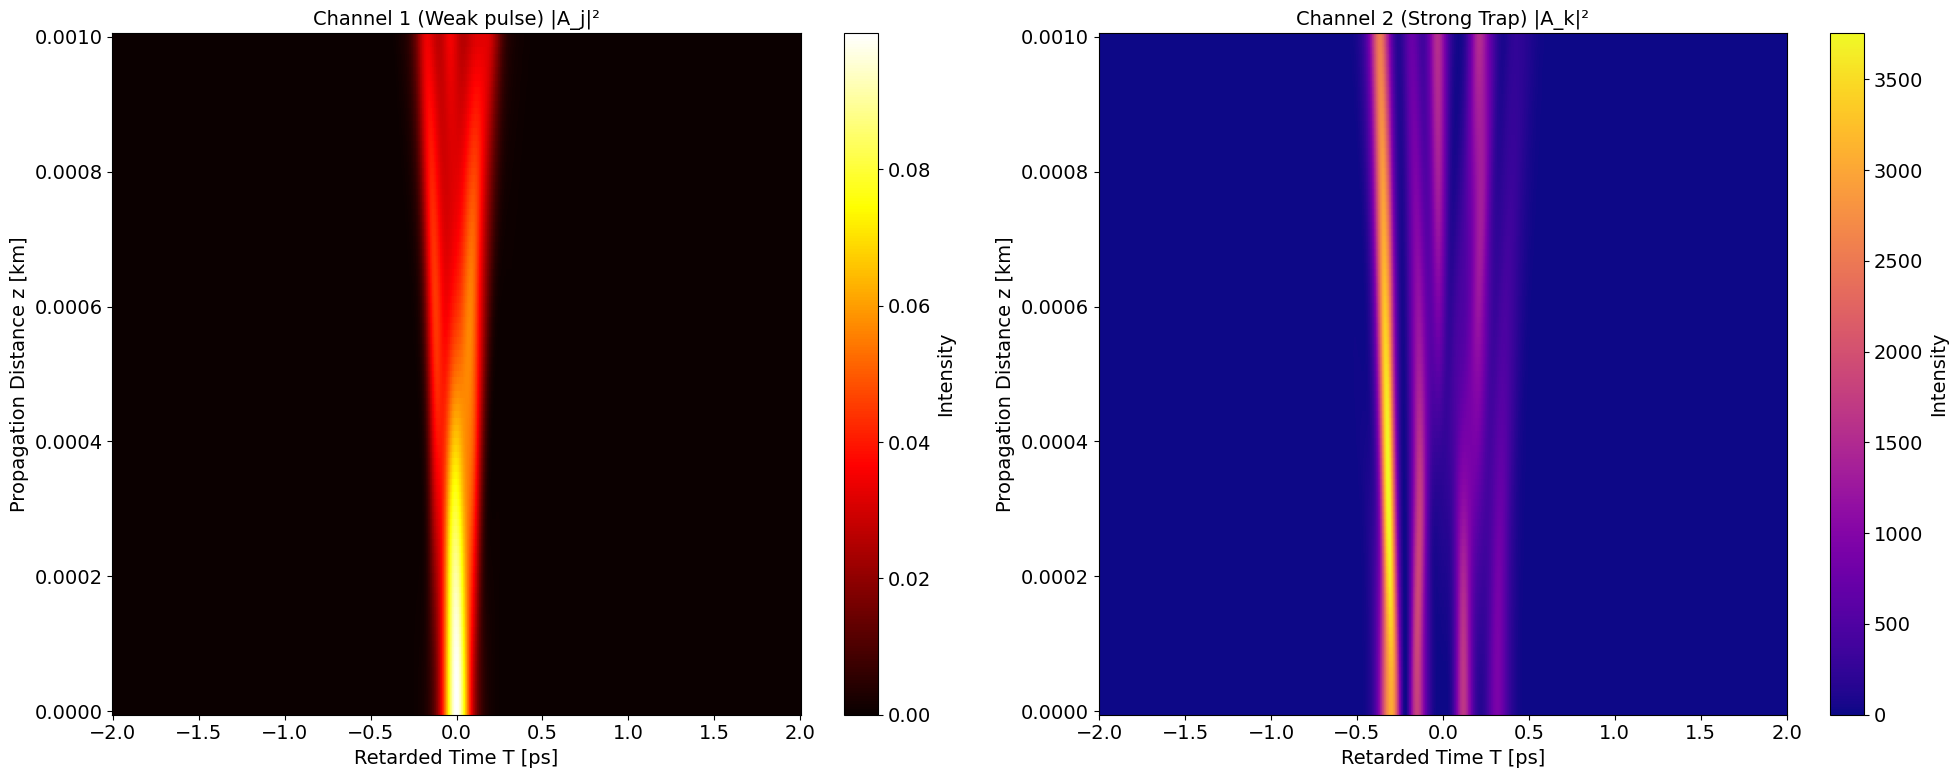

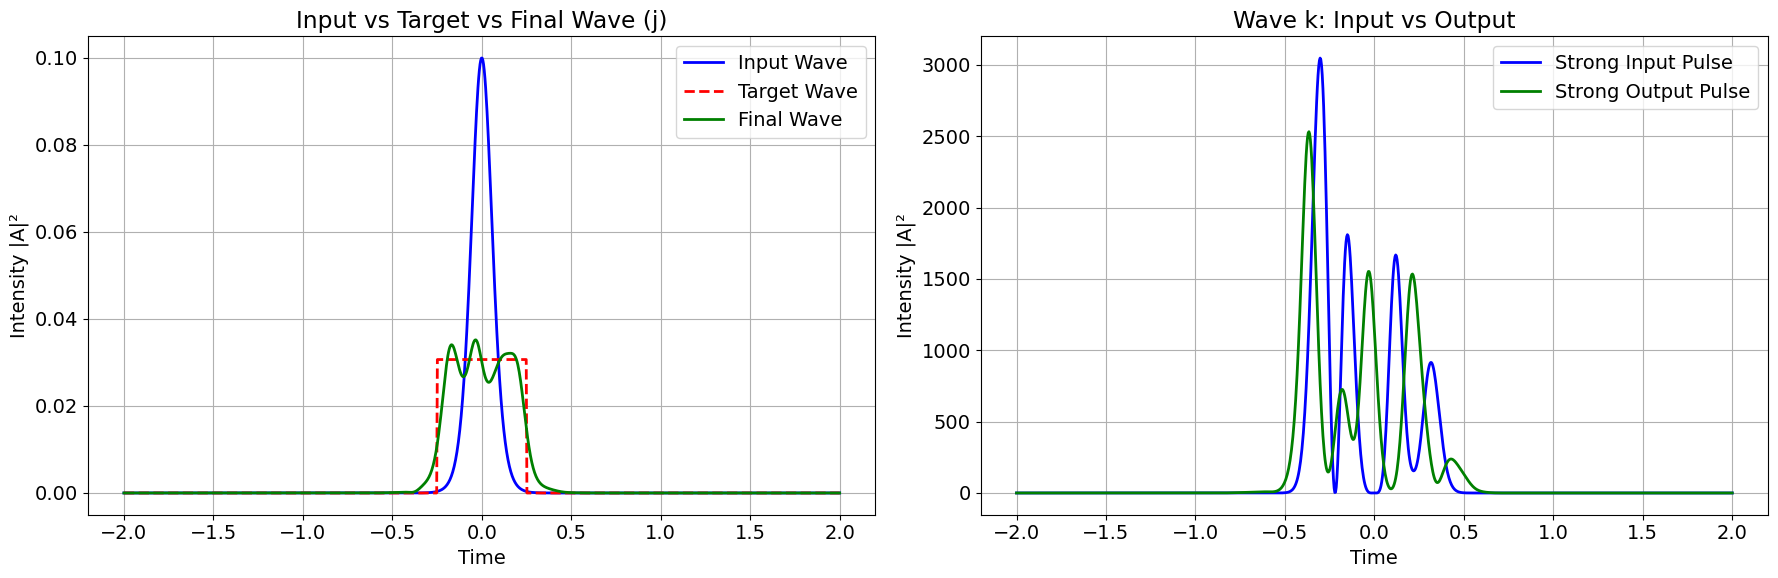

In [ ]:
# plot the loss
plt.figure(figsize=(10, 6))
plt.plot(losses, color='m', marker="o", label='Total Loss', linewidth=2, markersize=4)
plt.plot(losses_mse, color='b', marker="s", label='MSE Loss', linewidth=2, markersize=4)
plt.plot(losses_pen, color='r', marker="^", label='Penalty Loss', linewidth=2, markersize=4)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss Components')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# plot the evolution of the waves
plot_intensity_evolution(A_j_evolution, t, Lz, Nz, wave_name='Wave j')
plot_intensity_evolution(A_k_evolution, t, Lz, Nz, wave_name='Wave k')
plot_cowave_evolution(A_j_evolution.detach().clone(), A_k_evolution.detach().clone(), t, Lz, Nz)
# plot the target vs the final wave
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# First subplot: Wave j comparison
ax1.plot(t, np.abs(Ain_j.detach().cpu().numpy())**2, 'b-', label='Input Wave', linewidth=2)
ax1.plot(t, np.abs(A_target.detach().cpu().numpy())**2, 'r--', label='Target Wave', linewidth=2)
ax1.plot(t, np.abs(A_j_evolution[:, -1].detach().cpu().numpy())**2, 'g-', label='Final Wave', linewidth=2)
ax1.set_xlabel('Time')
ax1.set_ylabel('Intensity |A|²')
ax1.set_title('Input vs Target vs Final Wave (j)')
ax1.legend()
ax1.grid()

# Second subplot: Wave k first and last
ax2.plot(t, np.abs(A_k_evolution[:, 0].detach().cpu().numpy())**2, 'b-', label='Strong Input Pulse', linewidth=2)
ax2.plot(t, np.abs(A_k_evolution[:, -1].detach().cpu().numpy())**2, 'g-', label='Strong Output Pulse', linewidth=2)
ax2.set_xlabel('Time')
ax2.set_ylabel('Intensity |A|²')
ax2.set_title('Wave k: Input vs Output')
ax2.legend()
ax2.grid()

plt.tight_layout()
plt.show()

